In [ ]:
import sys
# Reconfigure stdout to use UTF-8 encoding (fixes UnicodeEncodeError on Windows)

import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # For formatting x-axis with years

import tensorflow as tf
from keras.api.models import Sequential
from keras.api.layers import *
from keras.api.optimizers import Adam
from sklearn.metrics import mean_squared_error


In [ ]:
def create_sequences(X, y, dates, time_steps):
    X_seq, y_seq, date_seq = [], [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
        date_seq.append(dates[i + time_steps])  # Store corresponding date
    return np.array(X_seq), np.array(y_seq), np.array(date_seq)

def load_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end, auto_adjust=False)

    if data.empty:
        print(f"Error: No data retrieved for {ticker}. Check API availability.")
        sys.exit(1)  # Stop the script if data is missing

    data.reset_index(inplace=True)
    return data


In [ ]:
def run_model(ticker, start, end):
    data = load_data(ticker, start, end)

    # Create target as next day's Adjusted Close price
    data['Target'] = data['Adj Close'].shift(-1)

    # Drop missing values
    data.dropna(inplace=True)

    # -----------------------------
    # 2. Select Features and Prepare Target
    # -----------------------------
    features = ['Volume', 'High', 'Low', 'Open', 'Close']
    X_raw = data[features].values

    # ✅ Use raw target prices (no log transformation)
    y_raw = data['Target'].values.reshape(-1, 1)

    # Convert `Date` column to datetime format for plotting
    data['Date'] = pd.to_datetime(data['Date'])


    # 3. Normalize Features and Target

    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X_raw)

    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y_raw)

    # -----------------------------
    # 4. Create Sequences for LSTM
    # -----------------------------
    time_steps = 90
    X_seq, y_seq, dates_seq = create_sequences(X_scaled, y_scaled, data['Date'].values, time_steps)

    # -----------------------------
    # 5. Train-Test Split (Preserving Time Order)
    # -----------------------------
    X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
        X_seq, y_seq, dates_seq, test_size=0.2, random_state=42, shuffle=False
    )

    # -----------------------------
    # 6. Build the LSTM Model
    # -----------------------------
    model = Sequential([
    Input(shape=(time_steps, len(features))),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    epochs = 10
    batch_size = 32

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=1
    )

    y_pred = model.predict(X_test)

    # ✅ Directly inverse transform predictions & true values
    y_pred_actual = scaler_y.inverse_transform(y_pred)
    y_test_actual = scaler_y.inverse_transform(y_test)

    # Compute MAE on the actual price scale
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae_percentage = mean_absolute_percentage_error(y_test_actual, y_pred_actual)

    return dates_test, y_test_actual, y_pred_actual, mae_percentage, rmse


In [ ]:
# Run the model
ticker = "^GSPC"
TRAIN_START = "2015-01-01"
TRAIN_END = "2025-01-01"

dates_test, y_test_actual, y_pred_actual, mae_percentage1, rmse1 = run_model(ticker, TRAIN_START, TRAIN_END)


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - loss: 0.0096 - val_loss: 0.0018
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 8.5171e-04 - val_loss: 4.8752e-04
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 7.5907e-04 - val_loss: 0.0012
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 7.3725e-04 - val_loss: 3.3925e-04
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 5.5760e-04 - val_loss: 0.0022
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 5.7406e-04 - val_loss: 3.3318e-04
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 5.5820e-04 - val_loss: 6.8859e-04
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - loss: 5.7379e-04 - val_loss: 3.3491e-04
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 6.2567e-04 - val_loss: 7.8634e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


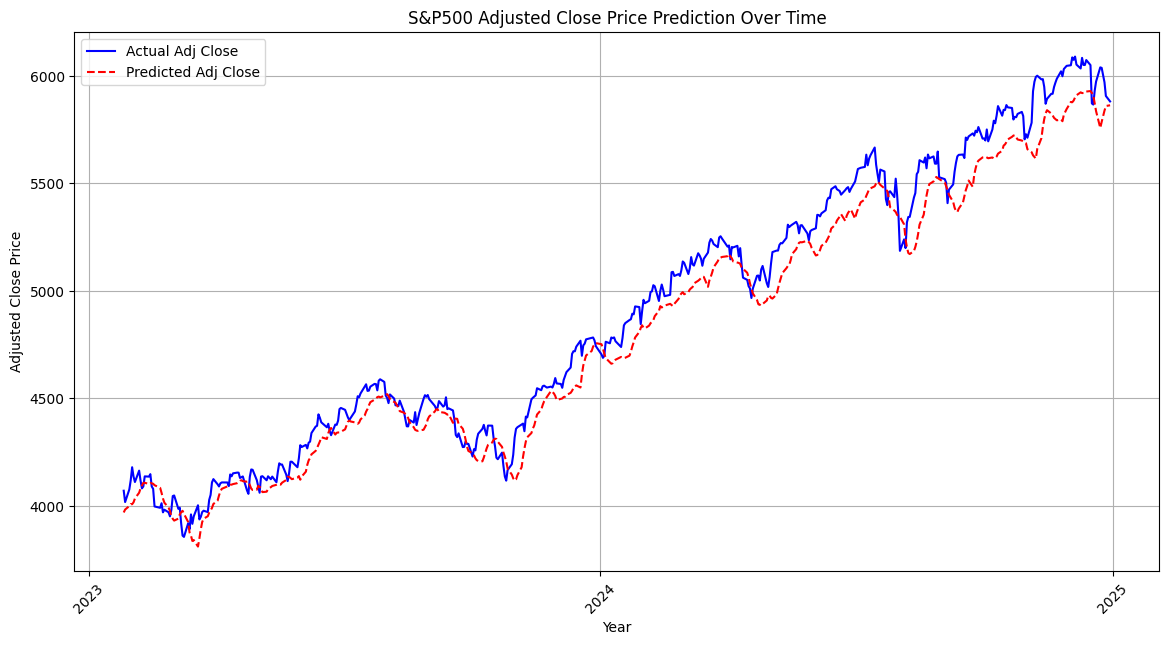

🔹 Mean Absolute Percentage Error : 0.019759671197861595
🔹Root Mean Squared Error (RMSE): 0.028041792619270235


In [ ]:

# ✅ Plot Predictions Outside Function
plt.figure(figsize=(14, 7))

# Plot actual prices
plt.plot(dates_test, y_test_actual, label="Actual Adj Close", color="blue")

# Plot predicted prices
plt.plot(dates_test, y_pred_actual, label="Predicted Adj Close", color="red", linestyle="dashed")

# Format x-axis to show years instead of individual days
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Show major ticks at each year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year only
plt.xticks(rotation=45)  # Rotate labels for readability

plt.xlabel("Year")
plt.ylabel("Adjusted Close Price")
plt.title("S&P500 Adjusted Close Price Prediction Over Time")
plt.legend()
plt.grid()
plt.show()


# Print evaluation metrics
print(f"🔹 Mean Absolute Percentage Error : {mae_percentage1}")
print(f"🔹Root Mean Squared Error (RMSE): {rmse1}")



In [ ]:
# Run the model
ticker = "^GSPC"
TRAIN_START = "2020-01-01"
TRAIN_END = "2025-01-01"

dates_test2, y_test_actual2, y_pred_actual2, mae_percentage2, rmse2 = run_model(ticker, TRAIN_START, TRAIN_END)


[*********************100%***********************]  1 of 1 completed

Epoch 1/10


30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - loss: 0.0552 - val_loss: 0.0021
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.0034 - val_loss: 0.0043
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.0015 - val_loss: 6.0075e-04
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0015 - val_loss: 5.8766e-04
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.0013 - val_loss: 0.0015
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


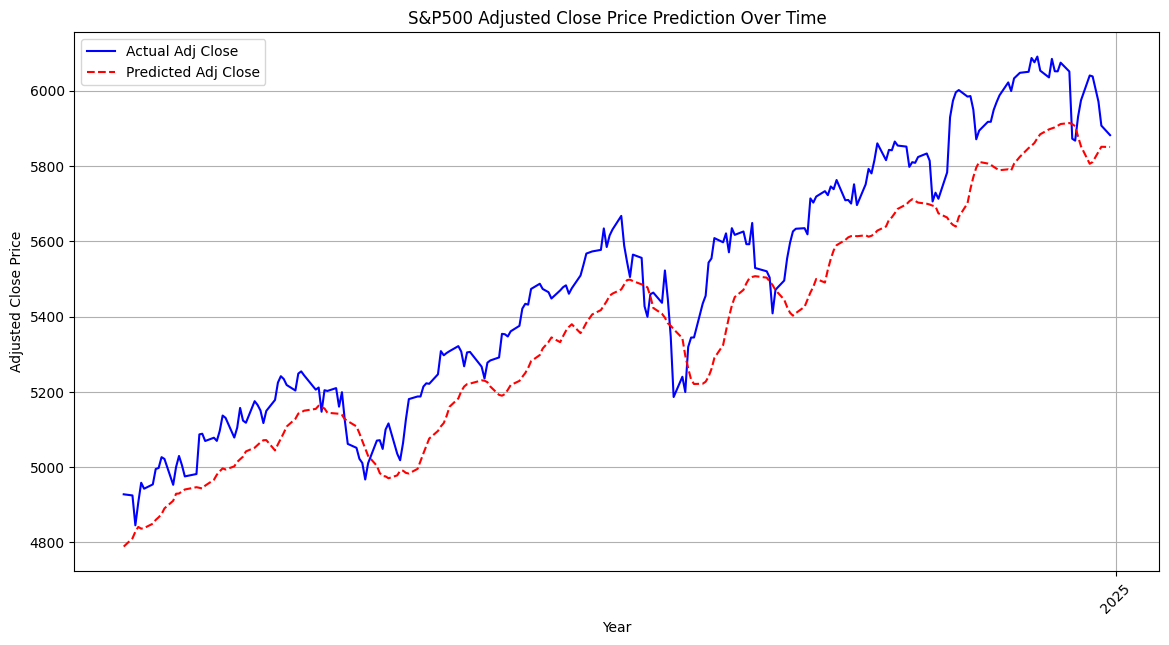

🔹  Mean Absolute Percentage Error: 0.023438519575017705
🔹 Root Mean Squared Error (RMSE): 0.038292073212135916


In [ ]:
plt.figure(figsize=(14, 7))

# Plot actual prices
plt.plot(dates_test2, y_test_actual2, label="Actual Adj Close", color="blue")

# Plot predicted prices
plt.plot(dates_test2, y_pred_actual2, label="Predicted Adj Close", color="red", linestyle="dashed")

# Format x-axis to show years instead of individual days
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Show major ticks at each year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year only
plt.xticks(rotation=45)  # Rotate labels for readability

plt.xlabel("Year")
plt.ylabel("Adjusted Close Price")
plt.title("S&P500 Adjusted Close Price Prediction Over Time")
plt.legend()
plt.grid()
plt.show()


# Print evaluation metrics
print(f"🔹  Mean Absolute Percentage Error: {mae_percentage2}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse2}")



In [ ]:
# Run the model
ticker = "^GSPC"
TRAIN_START = "2005-01-01"
TRAIN_END = "2025-01-01"

dates_test3, y_test_actual3, y_pred_actual3, mae_percentage3, rmse3 = run_model(ticker, TRAIN_START, TRAIN_END)


[*********************100%***********************]  1 of 1 completed

Epoch 1/10


124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - loss: 0.0103 - val_loss: 3.2423e-04
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - loss: 4.2311e-04 - val_loss: 7.3753e-04
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - loss: 3.3149e-04 - val_loss: 3.0280e-04
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - loss: 2.8786e-04 - val_loss: 2.7258e-04
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - loss: 2.8200e-04 - val_loss: 2.6730e-04
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 2.2322e-04 - val_loss: 5.2179e-04
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - loss: 2.3384e-04 - val_loss: 2.5929e-04
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - loss: 2.1827e-04 - val_loss: 2.9479e-04
Epoch 9/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - loss: 2.2585e-04 - val_loss: 2.9083e-04
Epoch 10/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - loss: 1.8920e-04 - val_loss: 4.6653e-04


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


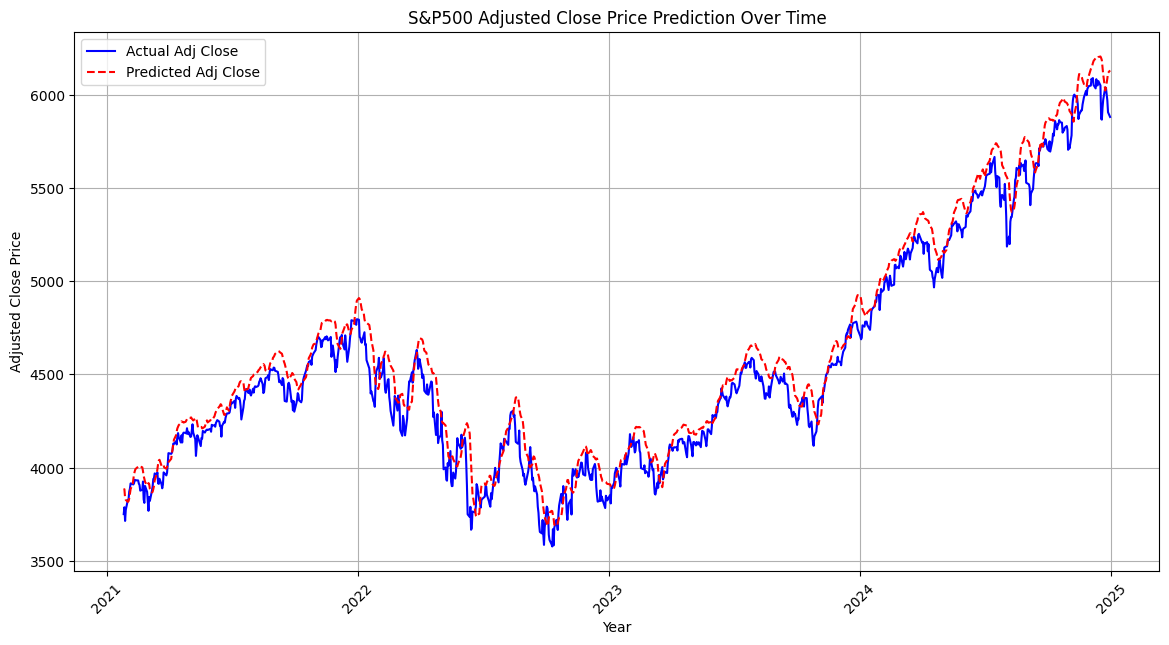

🔹 Mean Absolute Percentage Error: 0.020947181048036626
🔹 Root Mean Squared Error (RMSE): 0.02159919240879309


In [ ]:
plt.figure(figsize=(14, 7))

# Plot actual prices
plt.plot(dates_test3, y_test_actual3, label="Actual Adj Close", color="blue")

# Plot predicted prices
plt.plot(dates_test3, y_pred_actual3, label="Predicted Adj Close", color="red", linestyle="dashed")

# Format x-axis to show years instead of individual days
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Show major ticks at each year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year only
plt.xticks(rotation=45)  # Rotate labels for readability

plt.xlabel("Year")
plt.ylabel("Adjusted Close Price")
plt.title("S&P500 Adjusted Close Price Prediction Over Time")
plt.legend()
plt.grid()
plt.show()


# Print evaluation metrics
print(f"🔹 Mean Absolute Percentage Error: {mae_percentage3}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse3}")
